## Import Packages

In [21]:
import numpy as np
import pandas as pd
import pymatgen as pmg
import time
import matplotlib.pyplot as plt

from matminer.datasets.dataframe_loader import load_elastic_tensor
from matminer.utils.conversions import str_to_composition
from matminer.featurizers import composition as cf
from matminer.featurizers import structure as struc
from matminer.featurizers.base import MultipleFeaturizer

from pymatgen import MPRester

from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

## Load training datasets from elastic_tensor.csv 

In [2]:
data = load_elastic_tensor() 

Compute composition from formula of compound

In [3]:
data['composition'] = str_to_composition(data['formula'])

Unnecessary columns are dropped.

In [4]:
del_columns = ['formula', 'nsites', 'space_group', 
               'G_Reuss', 'G_Voigt', 'K_Reuss', 'K_Voigt',
               'compliance_tensor', 'elastic_tensor', 'elastic_tensor_original'
                ]

data = data.drop(del_columns, 1)

## Build ML models

### Part 1: Compute Representation (Featurization) 

In [5]:
key = 'ubX07DfzKy3mZAlw'

#### 1) Holder Means of first 8 properties in Table 1 of De Jong et al. paper 
'group_number', 'atomic_mass', 'atomic_radius', 'row_number', 'boiling_temp', 'melting_temp', 'electronegativity', 'atomic_number'

$$\mu_p(x) = [\frac{(\Sigma^n_{i=1}w_ix_i^p)}{(\Sigma^n_{i=1}w_i)}]^\frac{1}{p}$$

In [6]:
def holder_means(comp, prop, p):
    '''Input:
            - comp = (Series) containing Pymatgen.Composition datatype
            - prop = (string) consists of one of the following input:
                     {'group number', 'atomic_mass', 'atomic_radius', 'row_number', 'boiling_temp', 'melting_temp', 'electronegativity', 'atomic_number'}
            - p = (int) power of Holder means between -4 and 4
        Output:
            - pandas.Series 
    '''
    n = comp.shape[0]
    output = np.zeros((n,))
    for i in range(n):
        total_weight = comp[i].weight
        if (p == 0):
            for j in comp[i].get_el_amt_dict():
                el = pmg.Element(j)
                wt = el.atomic_mass
                d = {'group_number': el.group, 'atomic_mass': el.atomic_mass, 
                     'atomic_radius': el.atomic_radius, 'row_number': el.row, 
                     'boiling_temp': el.boiling_point, 'melting_temp': el.melting_point, 
                     'electronegativity': el.X, 'atomic_number': el.Z}
                
                output[i] += wt*np.log(d[prop])
            output[i] = output[i]/total_weight
        else:
            for j in comp[i].get_el_amt_dict():
                el = pmg.Element(j)
                wt = el.atomic_mass
                d = {'group_number': el.group, 'atomic_mass': el.atomic_mass, 
                     'atomic_radius': el.atomic_radius, 'row_number': el.row, 
                     'boiling_temp': el.boiling_point, 'melting_temp': el.melting_point, 
                     'electronegativity': el.X, 'atomic_number': el.Z}
                output[i] += wt*d[prop]**p
            output[i] = (output[i]/total_weight)**(1.0/p)
    output = pd.Series(output)
    output.name = prop + '_%s' %p
    return output

In [7]:
p = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
prop = ['group_number', 'atomic_mass', 'atomic_radius', 'row_number', 'boiling_temp', 'melting_temp', 'electronegativity', 'atomic_number']

for i in p:
    for j in prop:
        series = holder_means(data['composition'], j, i)
        data[series.name] = series

#### 2) Cohesive Energy

In [8]:
ft = cf.CohesiveEnergy(mapi_key=key)

data = ft.featurize_dataframe(data, col_id='composition', ignore_errors=True)

#### 3) Formation energy per atom, Energy above hull, band gap, density

In [9]:
# Formation energy per atom, Energy above hull, band gap, density
property_list = ['formation_energy_per_atom', 'e_above_hull', 'band_gap', 'density']

mp = MPRester(api_key=key)

n = data.shape[0]
E_f, E_hull, E_g, rho = pd.Series(index=np.arange(n)), pd.Series(index=np.arange(n)), pd.Series(index=np.arange(n)), pd.Series(index=np.arange(n))

for i in range(n):
    ls = mp.get_data(data['material_id'][i])
    if (ls==[]):
        E_f[i], E_hull[i], E_g[i], rho[i] = 0.0, 0.0, 0.0, 0.0
    else:
        E_f[i] = ls[0]['formation_energy_per_atom']
        E_hull[i] = ls[0]['e_above_hull']
        E_g[i] = ls[0]['band_gap']
        rho[i] = ls[0]['density']

data['formation energy per atom'] = E_f
data['energy above hull'] = E_hull
data['band gap'] = E_g
data['density'] = rho

#### 4) Volume (V) => log (V) per atom

In [10]:
data['log volume per atom'] = pd.Series(index=np.arange(n))
for i in range(len(data['volume'])):
    data['log volume per atom'][i] = np.log(data['volume'][i]/data['composition'][i].num_atoms)

#### 5) Voronoi based site coordination, bond lengths and bond angles

In [11]:
ft = MultipleFeaturizer([
    struc.SiteStatsFingerprint.from_preset("CoordinationNumber_ward-prb-2017"),
    struc.StructuralHeterogeneity()
])

data = ft.featurize_dataframe(data, col_id='structure')

In [12]:
data.head(1)

,material_id,volume,structure,elastic_anisotropy,G_VRH,K_VRH,poisson_ratio,composition,group_number_-4,atomic_mass_-4,...,avg_dev CN_VoronoiNN,mean absolute deviation in relative bond length,max relative bond length,min relative bond length,minimum neighbor distance variation,maximum neighbor distance variation,range neighbor distance variation,mean neighbor distance variation,avg_dev neighbor distance variation,mean absolute deviation in relative cell size
0,mp-10003,194.419802,"[[0.94814328 2.07280467 2.5112 ] Nb, [5.273...",0.030688,97.141604,194.268884,0.285701,"(Nb, Co, Si)",7.335929,54.688924,...,1.451453,0.048863,1.036647,0.911985,0.009816,0.080081,0.070264,0.058781,0.028399,0.105329


##### Data input

Here, we specify several different data sizes so that we can quantify performance of some machine learning algorithms with respect to the data input size. 

In [13]:
size = [10, 50, 100, 500, data.shape[0]]

variable_data = []
for i in range(len(size)):
    variable_data.append(shuffle(data)[:size[i]])

Elastic moduli value that we wish to predict. Choose from: "K_VRH" or "G_VRH"

In [14]:
learned_feature = 'G_VRH'

Input X and y 

In [15]:
original_columns = ['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
                    'K_VRH', 'poisson_ratio', 'structure', 'composition']

X = []
y = []
I = Imputer()
for i in range(len(variable_data)):
    x = variable_data[i].drop(original_columns, 1)
    X.append(I.fit_transform(x))
    y.append(np.log(variable_data[i][learned_feature]).as_matrix())

### Part 2: Choosing different ML models

We use several different ML algorithms to train the training set. Time performance and accuracy of the predictions of the respective models are printed. 

##### 5-fold cross-validation

In [16]:
num_splits = 5
kfold = KFold(num_splits, shuffle=False, random_state=0)

In [17]:
m = len(size)

#### 1) Generalized Linear Models: Linear Regression

In [18]:
mae_lr, rmse_lr, r2_lr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [19]:
time_lr = np.zeros((m,))

In [22]:
print ("Linear Regression: ")
start_lr = time.monotonic()
for i in range(m):
    start_lr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        lr = linear_model.LinearRegression()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        lr.fit(x_train, y_train)
        y_pred = lr.predict(x_test)

        mae_lr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_lr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_lr[i] += r2_score(y_test, y_pred) / num_splits

    finish_lr = time.monotonic()
    time_lr[i] = finish_lr - start_lr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_lr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_lr[i], rmse_lr[i], r2_lr[i]))
print ()

Linear Regression: 
-- Size of dataset: 10
Time: 0.011877 seconds
MAE = 0.459466, RMSE = 2.433196, R-SQUARED = -2.366173
-- Size of dataset: 50
Time: 0.008497 seconds
MAE = 1.189735, RMSE = 8.425721, R-SQUARED = -14.082289
-- Size of dataset: 100
Time: 0.012896 seconds
MAE = 1.289291, RMSE = 11.188604, R-SQUARED = -44.762935
-- Size of dataset: 500
Time: 0.022239 seconds
MAE = 0.291928, RMSE = 2.130505, R-SQUARED = 0.628392
-- Size of dataset: 1181
Time: 0.044076 seconds
MAE = 0.255918, RMSE = 1.762886, R-SQUARED = 0.771587



/Users/AikRui/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



#### 2) Generalized Linear Model:  Ridge Regression

In [23]:
mae_ridge, rmse_ridge, r2_ridge = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [24]:
time_ridge = np.zeros((m,))

In [25]:
print ("Ridge Regression: ")
for i in range(m):
    start_ridge = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        ridge = linear_model.RidgeCV()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        ridge.fit(x_train, y_train)
        y_pred = ridge.predict(x_test)

        mae_ridge[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_ridge[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_ridge[i] += r2_score(y_test, y_pred) / num_splits
    finish_ridge = time.monotonic()
    time_ridge[i] = finish_ridge - start_ridge
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_ridge[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_ridge[i], rmse_ridge[i], r2_ridge[i]))
print ()

Ridge Regression: 
-- Size of dataset: 10
Time: 0.013512 seconds
MAE = 0.485153, RMSE = 2.538676, R-SQUARED = -2.922306
-- Size of dataset: 50
Time: 0.012089 seconds
MAE = 0.600805, RMSE = 3.725521, R-SQUARED = -0.464448
-- Size of dataset: 100
Time: 0.011416 seconds
MAE = 0.385979, RMSE = 2.554032, R-SQUARED = -0.032168
-- Size of dataset: 500
Time: 0.034197 seconds
MAE = 0.271448, RMSE = 1.858291, R-SQUARED = 0.709187
-- Size of dataset: 1181
Time: 0.072119 seconds
MAE = 0.261553, RMSE = 1.805698, R-SQUARED = 0.759827



#### 3) Ensemble method: RandomForestRegressor 

100 estimators are used

In [26]:
num_trees = 100

In [27]:
mae_rfr, rmse_rfr, r2_rfr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [28]:
time_rfr = np.zeros((m,))

In [29]:
print ("Random Forest Regression: ")
for i in range(m):
    start_rfr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        rfr = RandomForestRegressor(n_estimators=num_trees)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        rfr.fit(x_train, y_train)
        y_pred = rfr.predict(x_test)

        mae_rfr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_rfr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_rfr[i] += r2_score(y_test, y_pred) / num_splits
    finish_rfr = time.monotonic()
    time_rfr[i] = finish_rfr - start_rfr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_rfr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_rfr[i], rmse_rfr[i], r2_rfr[i]))
print ()

Random Forest Regression: 
-- Size of dataset: 10
Time: 0.453045 seconds
MAE = 0.505396, RMSE = 2.987255, R-SQUARED = -3.750499
-- Size of dataset: 50
Time: 0.722829 seconds
MAE = 0.476546, RMSE = 3.077555, R-SQUARED = -0.002878
-- Size of dataset: 100
Time: 1.258319 seconds
MAE = 0.381386, RMSE = 2.345168, R-SQUARED = 0.349156
-- Size of dataset: 500
Time: 6.143850 seconds
MAE = 0.276018, RMSE = 1.891307, R-SQUARED = 0.699966
-- Size of dataset: 1181
Time: 17.284821 seconds
MAE = 0.256678, RMSE = 1.798980, R-SQUARED = 0.759869



#### 4) Ensemble method: ExtraTreesRegressor

In [30]:
mae_efr, rmse_efr, r2_efr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [31]:
time_efr = np.zeros((m,))

In [32]:
print ("Extra Trees Regression: ")
for i in range(m):
    start_efr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        efr = ExtraTreesRegressor(n_estimators=num_trees)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        efr.fit(x_train, y_train)
        y_pred = efr.predict(x_test)

        mae_efr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_efr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_efr[i] += r2_score(y_test, y_pred) / num_splits
    finish_efr = time.monotonic()
    time_efr[i] = finish_efr - start_efr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_efr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_efr[i], rmse_efr[i], r2_efr[i]))
print ()

Extra Trees Regression: 
-- Size of dataset: 10
Time: 0.420811 seconds
MAE = 0.537640, RMSE = 3.158748, R-SQUARED = -4.785933
-- Size of dataset: 50
Time: 0.650106 seconds
MAE = 0.463735, RMSE = 2.932742, R-SQUARED = 0.050981
-- Size of dataset: 100
Time: 0.943562 seconds
MAE = 0.390171, RMSE = 2.361513, R-SQUARED = 0.288704
-- Size of dataset: 500
Time: 3.473581 seconds
MAE = 0.273513, RMSE = 1.860963, R-SQUARED = 0.711756
-- Size of dataset: 1181
Time: 7.959894 seconds
MAE = 0.246406, RMSE = 1.743380, R-SQUARED = 0.774512



#### 5) Ensemble method: GradientBoosting 

In [33]:
mae_gradient, rmse_gradient, r2_gradient = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [34]:
time_gradient = np.zeros((m,))

In [35]:
print ("Gradient Boosting Regression: ")
for i in range(m):
    start_gradient = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        gradient = GradientBoostingRegressor(n_estimators=250, max_depth=3)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        gradient.fit(x_train, y_train)
        y_pred = gradient.predict(x_test)

        mae_gradient[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_gradient[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_gradient[i] += r2_score(y_test, y_pred) / num_splits
    finish_gradient = time.monotonic()
    time_gradient[i] = finish_gradient - start_gradient
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_gradient[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_gradient[i], rmse_gradient[i], r2_gradient[i]))
print ()

Gradient Boosting Regression: 
-- Size of dataset: 10
Time: 0.195547 seconds
MAE = 0.551854, RMSE = 3.188122, R-SQUARED = -4.718524
-- Size of dataset: 50
Time: 0.406360 seconds
MAE = 0.498376, RMSE = 3.119780, R-SQUARED = -0.050016
-- Size of dataset: 100
Time: 0.997919 seconds
MAE = 0.368693, RMSE = 2.273011, R-SQUARED = 0.343916
-- Size of dataset: 500
Time: 3.876895 seconds
MAE = 0.260668, RMSE = 1.787734, R-SQUARED = 0.727664
-- Size of dataset: 1181
Time: 8.425930 seconds
MAE = 0.239608, RMSE = 1.718009, R-SQUARED = 0.782069



#### Quantifying trade off of time performance and accuracy of model with respect to size of data 

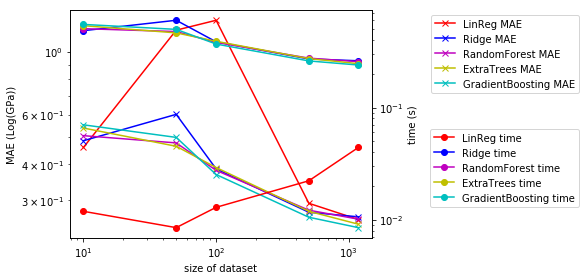

In [36]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_lr, color='r', marker='x', label='LinReg MAE')
ax1.loglog(size, mae_ridge, color='b', marker='x', label='Ridge MAE')
ax1.loglog(size, mae_rfr, color='m', marker='x', label='RandomForest MAE')
ax1.loglog(size, mae_efr, color='y', marker='x', label='ExtraTrees MAE')
ax1.loglog(size, mae_gradient, color='c', marker='x', label='GradientBoosting MAE')
ax1.legend(bbox_to_anchor=(1.7, 1))

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_lr, color='r', marker='o', label='LinReg time')
ax2.loglog(size, mae_ridge, color='b', marker='o', label='Ridge time')
ax2.loglog(size, mae_rfr, color='m', marker='o', label='RandomForest time')
ax2.loglog(size, mae_efr, color='y', marker='o', label='ExtraTrees time')
ax2.loglog(size, mae_gradient, color='c', marker='o', label='GradientBoosting time')
ax2.legend(bbox_to_anchor=(1.7, 0.5))

fig.tight_layout()
plt.show()